# Lectura de datos

Cargamos las librerias. Keras es la mejor libreria de deep learning para principiantes.

In [73]:
import numpy as np 
import pandas as pd 
import os
import pandas as pd
import numpy as np
import keras
import pickle

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Dense, Dropout, Bidirectional,LSTM,Embedding,TimeDistributed,Flatten
from sklearn.preprocessing import LabelBinarizer
import sklearn.datasets as skds
from pathlib import Path
import keras.optimizers

In [74]:
import keras
import tensorflow as tf

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14467459204623485663
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9224895857
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8469586347251662397
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


Leemos nuestro train.xlsx y mostramos las clases con os que vamos a clasificar nuestros tweets

In [75]:
data = pd.read_excel('train-20190402-08_55_19.xlsx') # Load the `train` file
data = data.sample(frac=1) # Show a sample of the dataset

print(set(data.party.values))
print(len(list(data['text'].str.split(' ', expand=True).stack().unique())))

{'cup', 'bcomu', 'jxcat', 'pp', 'bcncapital', 'erc', 'vallsbcn', 'psc'}
48789


In [76]:
data.head()

,Id,username,party,text,created_at,retweet_count,favorite_count
1539,1539,ejimenezcara,pp,Intento pensar en cómo fueron los últimos mome...,2018-12-18 15:43:16,21,26
2775,2775,manuelvalls,vallsbcn,En febrero del 2015 en Argelès celebré la mem...,2019-02-25 07:28:09,27,74
1667,1667,Jaumeasens,bcomu,"Los q dicen q no hay corporativismo, corrupció...",2019-01-27 13:47:17,537,710
4745,4745,junqueras,erc,"Oriol Junqueras: ""Cada gesto de respeto hacia ...",2017-12-27 16:39:49,1887,4860
1214,1214,G_Pisarello,bcomu,Mi amigo @mrenau me envía esta nota de @minimo...,2019-04-01 20:40:32,44,102


In [77]:
data.describe()

,Id,retweet_count,favorite_count
count,7219.000000,7219.000000,7219.000000
mean,3609.000000,285.129104,697.784042
std,2084.090129,920.072538,2261.900104
min,0.000000,0.000000,0.000000
25%,1804.500000,7.000000,14.000000
50%,3609.000000,24.000000,44.000000
75%,5413.500000,101.500000,226.500000
max,7218.000000,17034.000000,47522.000000


Dividimos nuestro dataset en training y test. El propio algoritmo de red neuronal de keras nos separara el set de validacion asi que ahora no nos preocupamos de esto.

In [78]:
train_size = int(len(data) * .8)

train_posts = data['text'][:train_size]
train_tags = data['party'][:train_size]

test_posts = data['text'][train_size:]
test_tags = data['party'][train_size:]

In [79]:
import re
import nltk
from nltk.corpus import stopwords 
nltk.download('stopwords')

def get_full(username, df):
    """ Get all tweets from a user
    """
    text_series = df[df['username'] == username]['text']
    all_text = " ".join(text_series)
    return all_text
  
def filter_single(text):
    """remove all single characters
    """
    return re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

def get_full_party(party, df):
    """ Get all tweets from a party
    """
    text_series = df[df['party'] == party]['text']
    all_text = " ".join(text_series)
    return all_text

def stop_words():
    """ Get the stop words
    """
    #stpwords=stopwords.words('catalan')
    stpwords=stopwords.words('english')
    stpwords+=stopwords.words('spanish')
    stpwords.append("dels")
    stpwords.append("als")
    stpwords.append("q")
    stpwords.append("hem")
    stpwords.append("d'")
    stpwords.append("d’")
    stpwords.append("ho")
    stpwords.append("hi")
    stpwords.append("pel")
    return stpwords
    
def filter_mentions(text):
    """ Filter all mentions
    """
    return re.sub("@\S+", "", text)

def filter_hashtags(text):
    """ Filter all hashtags
    """
    return re.sub("#\S+", "", text)

def get_hashtags_only(text):
    """
    """
    return re.findall("#\S+", text)
def clean_text(text):
    text = re.sub(r" c s ", " cs ", text)
    text = re.sub(r"à", "a", text)
    text = re.sub(r"á", "a", text)
    text = re.sub(r"è", "e", text)
    text = re.sub(r"é", "e", text)
    text = re.sub(r"ò", "o", text)
    text = re.sub(r"ó", "o", text)
    text = re.sub(r"í", "i", text)
    text = re.sub(r"ú", "u", text)
    text = text.lower()
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text
# aqui pasamos el clean_text
stop = stop_words()
train_posts = train_posts.map(lambda com : clean_text(com))
train_posts = train_posts.apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))
test_posts = test_posts.map(lambda com : clean_text(com))
test_posts = test_posts.apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\usuario\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


En esta celda definimos el numero de labels (partidos pol�ticos), numero de palabras en nuestro bag of words (vocab_size) y el batch size que es el numero de tweets que la red neuronal va a entrenar en cada step. El batch size existe porque si pasaramos de uno en uno los tweets el entrenamiento seria eterno. Adem�s generamos el tokenizador con nuestro vocabulario y lo integramos para nuestros tweets de training. Una vez generado este tokenizador lo aplicamos tanto en los tweets de test y los de train. Con esto obtenemos el vector de caracteristicas. Importante que nuestro contador tiene en cuenta la frequencia de la palabra y su aparacion en todos los tweets (mode = "tfidf").

In [80]:
num_labels = 6
vocab_size = 30000  #25000
batch_size = 10  #100
lenght = 50
# define Tokenizer with Vocab Size
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_posts)
from keras import preprocessing

x_train = tokenizer.texts_to_sequences(train_posts)
x_test = tokenizer.texts_to_sequences(test_posts)
x_train = preprocessing.sequence.pad_sequences(x_train,lenght)
x_test = preprocessing.sequence.pad_sequences(x_test,lenght)
print(x_train[0])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0  2872   522  2211  2510  2511 10425  5071  3333    15  6811  3334
    15 10426   237   293    15  5072  3997 10427  5073  2212  2511 10428
  6812 10429]


En esta celda pasamos de labels categoricas a lables vecotrizadas que es lo que la red neuronal entiende. Ej pp = [0,1,0,0,0,0] psc = [0,0,0,0,0,1]

In [81]:
encoder = LabelBinarizer()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

# Neural Network

En estas celdas definimos el modelo, es dificil explicar DL aqui mismo pero os dejo un video muy basico para haceros una idea https://www.youtube.com/watch?v=aircAruvnKk

In [82]:
num_epochs = 10 # 5

In [83]:
model = Sequential()
model.add(Embedding(vocab_size,100,input_length=lenght))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(8,activation="softmax"))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.save_weights('model.h5')
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 100)           3000000   
_________________________________________________________________
flatten_6 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               2560512   
_________________________________________________________________
activation_11 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               131328    
_________________________________________________________________
activation_12 (Activation)   (None, 256)               0         
__________

En esta celda evaluamos nuestro modelo y mostramos las prediciones en el test. Por peticion popular ahora solo se muestran los errores.

In [84]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)

print('Test accuracy:', score[1])

text_labels = encoder.classes_

predicted_label = [0] * len(x_test)
for i in range(len(x_test)):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label[i] = text_labels[np.argmax(prediction[0])]
    if test_tags.iloc[i] != predicted_label[i]:
        print('Text:' + data["text"][train_size+i])
        print('Actual label:' + test_tags.iloc[i])
        print("Predicted label: " + predicted_label[i])

1444/1444 [==============================] - 0s 97us/step
Test accuracy: 0.4903047147756468
Text:Comença el #MWC19 el gran aparador per mostrar la cara més sofisticada i amigable de les corporacions que any rere any van guanyant terreny en la cursa per l'acumulació de riquesa. Traient benefici de precaritzar, espoliar riqueses, traficar amb dades...
Llarga vida al Mobile! 
Actual label:jxcat
Predicted label: bcncapital
Text:Sentir @jcuixart. Recordar el 20S. I afirmar amb orgull que hi érem i que hi tornaríem a ser. 

#EndavantCuixart 
#JudiciFarsa 
Actual label:jxcat
Predicted label: bcncapital
Text:La vida a les ciutats està amenaçada per la gentrificació. Avui a Brussel·les proposem que Europa:
⛔prohibeixi les GoldenVisa
✅promogui un impost contra l’especulació immobiliària
✅impulsi un Pla de Rescat per barris vulnerables
#Eurocities #Cities4Europe 
Actual label:bcncapital
Predicted label: bcomu
Text:Seguim a #Gràcia compartint propostes i idees amb més veïnes i veïnes. Hem parlat s

Text:Ese momento en el que @jordievole le pone a Mònica Terribas la grabación con sus propias palabras explicando desde los medios públicos que ya era una realidad la República Catalana. Su contribución a la farsa procesista fue encomiable @salvadostv #SalvadosProcés #BouBCN2019 
Actual label:bcncapital
Predicted label: cup
Text:Las reglas de la democracia en España no son sencillas. 
No todo el mundo conoce la Ley d’Hondt y es difícil de explicar. 
Pero lo que se entiende muy bien es que presidentes sólo podrán ser dos: o SANCHEZ o CASADO. 
Hay que escoger y darle el voto.

 #ObjetivoCasado
Actual label:cup
Predicted label: bcncapital
Text:Hoy desde Cúcuta, Colombia, la Coalición Ayuda y Libertad Venezuela; muestran como el esfuerzo conjunto llevará a los venezolanos la ayuda humanitaria que tanto necesitan.
Nadie impedirá que sigan  dando pasos importantes hacia la libertad. #VamosBien #Venezuela 
Actual label:jxcat
Predicted label: pp
Text:Avui és el dia mundial de l'aigua, per això

Text:Magnífica jornada de debat al @CdEconomia sobre el model territorial. Hi ha idees, hi ha coneixement. "Només" cal voluntat de tots els actors polítics 
Actual label:cup
Predicted label: erc
Text:Es una vergüenza lo de @QuimTorraiPla y la #seguridad. Cierra una comisaría durante 16 meses con la excusa de hacer obras. No hace obras, pero tampoco molesta a los delincuentes #BouBCN2019 #delincuencia #stopokupas #inseguridad #topmanta 

Actual label:jxcat
Predicted label: vallsbcn
Text:Veo q Puigdemont y @EnricJuliana NO saben que yo voté en contra del tratado con África del sur precisamente por las naranjas valencianas. No me va a dar lecciones de defender a España y a Cataluña uno que dejó a los suyos tirados, que le pudo más el miedo que el amor a la tierra.
Actual label:jxcat
Predicted label: bcncapital
Text:Demà les rieres i torrents del camp de Tarragona semblaran el Nil. Tarragonins, demà el cotxe es queda ben tranquilet a casa. #LeslieCat 
Actual label:jxcat
Predicted label: cu

Text:Este es el resumen. En su día nos encontraremos en las urnas con dos proyectos ideológicos antagónicos y dos percepciones de la política muy diferentes: no todo vale. #YoNoVoy 
Actual label:cup
Predicted label: jxcat
Text:La ciutat reclama i espera respostes. Parlem de la Barcelona d’avui i de demà?
Guarda’t el vespre del dilluns 10 de desembre! 
Actual label:pp
Predicted label: psc
Text:Bona notícia i bona feina! Perquè quan els problemes se solucionen hi surt guanyant tothom. #CapRaval 
Actual label:cup
Predicted label: jxcat
Text:Com Ulisses, l'independentisme haurà de superar proves per arribar a la seva Ítaca. Una d'elles és la de saber ignorar els intoxicadors. N'hi ha d'enemics i n'hi ha d'amics. Els segons són més perillosos 
Actual label:erc
Predicted label: bcncapital
Text:Gràcies veïns i veïnes de la #Guineueta per venir a #TrobadesAcaldessa a compartir dubtes, queixes i propostes pel barri i la ciutat. Aquesta ha estat la última Trobada del mandat. 38 trobades, 44 barr

Text:#5dones , anem sumant hem de ser moltes més!
@malonsoiz @lourdesg2a @AlbaMetge @nanasalvador @t_capdevila
Actual label:cup
Predicted label: erc
Text:460 persones ens hem trobat avui al Sopar groc de Sants-Monjuïc. Persistim, resistim i exigim #LlibertatPresesPolítiques #LlibertatPresosPolítics Seguirem tossudament alçades fins a la victòria. 
Actual label:erc
Predicted label: bcomu
Text:Des d’ahir estic rebent constants mostres de suport i escalf de persones per davant de tot demòcrates.
Gairabé totes acaben amb un “ens en sortirem”
Ja ho crec que ens en sortirem! Plegades persistirem amb fermesa en la defensa dels drets civils i polítics i les llibertats.
Actual label:pp
Predicted label: psc
Text:Estas son las mejores terrazas de Lisboa 😍🇵🇹🍹 #Travels #Lisboa #Alfacinha #PT #Rooftops  vía @CNTravelerSpain
Actual label:pp
Predicted label: vallsbcn
Text:Ahir vaig estar a @basicsbtv parlant del CAP del Raval Nord @NordRaval i la votació de divendres que ve. 
Cal prioritzar la ciutat,

Text:Ara mateix a #Terrassa amb el @salvadorcot i la @BeatrizTalegon 

I centenars d’egarencs i egarenques com en @miquelsamper 
Actual label:bcomu
Predicted label: cup
Text:Madrid es una ciudad maravillosa, abierta y libre.

Tiene que ser muy triste y penoso vivir con tanto odio. 
Actual label:erc
Predicted label: bcncapital
Text:Comença el debat “Els reptes de la Ciència” amb dos premis nobels, una astronauta i un bon científic de @ICFOnians . Ho presenta @TxellBonet i fa les ilustracions del debat la gran Pilarin Bayés #CiutatiCiència 
Actual label:bcncapital
Predicted label: erc
Text:Aquesta tarda el @PhenomenaExp inaugura un nou sistema de so convertint la seva sala en una referència global per a tots els cinemes. A més d'oferir una experiència audiovisual única, situa Barcelona al capdavant de la innovació cultural. Endavant Phenomena! #estimoBCN/❤ 
Actual label:cup
Predicted label: bcncapital
Text: «Los se­pa­ra­tis­tas ca­ta­la­nes han crea­do una fan­ta­sía y vi­ven en su pro­

Text:“Són les grans ciutats les que tenim la necessitat de defensar multiculturalitats obertes i modernes que no tenen por al futur. Podem donar igualtat i seguretat. Aquest ha de ser el nostre compromís també a les eleccions europees ” @jaumecollboni #ReconstruïmEuropa 
Actual label:pp
Predicted label: psc
Text:#Davos2019 és el moment per recordar les desigualtats que pateix la nostra societat: el 85% de la riquesa generada en l'últim any es va destinar a l'1% de la població global més rica. 

Ho he explicat a #RawPolitics d'@euronews 👇 
Actual label:bcomu
Predicted label: vallsbcn
Text:Com era evident, el calendari no s’està respectant

Al llarg del matí només han pogut declarar 3 testimonis

Montoro passa a la tarda. Després altres 4 testimonis començant per M. Rajoy

Es preveu jornada llarga (i a les 21 partit de Copa)

Perdrà avui la paciència el president?
Actual label:bcomu
Predicted label: psc
Text:🔴 Manifestacions de suport a la companya antifeixista empresonada⬇️
Dilluns 01:


Text:Hoy se conmemora el Día Internacional de las Víctimas  del Holocausta. El 27 de enero del 1945 fue el día de la liberación de Auschwitz-Birkenau. No olvidamos jamás! #WeRemenber #HMD2019 #Auschwitz 
Actual label:pp
Predicted label: vallsbcn
Text:Pedro Sanchez ha fet entrar el 155 en campanya. Iceta diu ara que no serà permanent. Catalunya necessita avançar, no retrocedir. Cal reforçar l'autogovern, no un pacte amb Ciutadans q el posi en risc. 
Actual label:vallsbcn
Predicted label: pp
Text:És curiós que d’aquest article @josebouvila no hagi preferit destacar que l’@ernestmaragall va criticar els especuladors que provoquen l’exclusió de la gent de Barcelona. Qüestió de principis 
Actual label:bcncapital
Predicted label: jxcat
Text:A @LaPedrera_BCN i dins la Biennal #CiutatiCiència es parla d’alimentació saludable i sostenible amb @ToniMassanes Elena Roura, Jesús Contreras i @saez_cristina 
Actual label:psc
Predicted label: bcomu
Text:Una de les activitats més especials de la Bienna

Text:La matinada d’avui fa 78 anys el President Lluis Companys va ser afusellat. El seu darrer crit fou “Per Catalunya!”. Honorem-lo amb l’esperit d’aquell tambe seu “Tornarem a sofrir, tornarem a lluitar i tornarem a vèncer!”. Memòria, lluita i compromís.
Actual label:jxcat
Predicted label: erc
Text:Les imatges d’avui de la Gran Via amb centenars de milers de persones són espectaculars. Barcelona, cap i casal, ha tornat a acollir una demostració del que som, del que volem i com ho volem. Junts som imparables. Gràcies a tothom! #AutodeteminacióNoÉsDelicte #FreeTothom 
Actual label:pp
Predicted label: vallsbcn
Text:Gran acollida a la iniciativa de “La nit de les acadèmies” dins la Biennal #CiutatiCiència Moltes gràcies a @RACABarcelona @CSICCat @BiblioCatalunya @iec Reial Acadèmia de Farmàcia i Reial Acadèmia de Medicina 
Actual label:erc
Predicted label: bcncapital
Text:Centímetre a centímetre els barris es defensen de l'avarícia dels especuladors desbocada per la indiferència de les a

Text:El Ayto de #bcn ha acumulado 21Millones€ de beneficios en 10 años solo con los cementerios, cobrando tasas funerarias al máximo. Por qué no las baja Colau hoy mismo? Por qué solo utiliza los funerales para buscar titulares que tapen sus fracasos #noalademagogia #StopColau
Actual label:vallsbcn
Predicted label: cup
Text:La jutge de Manresa sí que farà visionar vídeos als guàrdies civils durant el seu testimoni per l'1-O 

| NacióManresa 
Actual label:vallsbcn
Predicted label: erc
Text:Gràcies @AdaColau @G_Pisarello @Jaumeasens  @miquelessomba @MJLecha Irma Rognoni @JaumeCiurana @carmenandres_  per la vostra solidaritat en aquests moments.
Actual label:vallsbcn
Predicted label: bcomu
Text:9è dia #vagadefam
L’acusat d'un delicte té el dret que hom presumeixi la seva innocència fins que no se’n provi la culpabilitat (art 11 de la Decl Univ de Drets Humans)
Exigim que s’apliqui
Llibertat és sentir-vos a l’altra banda i saber que no estem sols

 
Actual label:jxcat
Predicted label: erc


Text:Espanya té una representant que va pel món condemnant gent que no ha estat jutjada. Una seguretat jurídica de nassos. Però cap propaganda no taparà la dignitat de @ForcadellCarme @jordialapreso @jcuixart @quimforn @junqueras @jorditurull @raulromeva @joseprull @dolorsbassac 
Actual label:erc
Predicted label: jxcat
Text:Importante! El Parlamento Europeo bloqueará la semana que viene los nombramientos en instituciones financieras europeas por falta de mujeres, si antes no llega un compromiso por escrito de Comisión y Consejo garantizando paridad en próximos nombramientos. 
Actual label:bcomu
Predicted label: psc
Text:“Agraïts per la visita i per la interessant conversa. 
Constatem les diferències que ens separen però també les moltes coses que ens uneixen. 
Seguim! Abraçada @Pablo_Iglesias_ “
Actual label:bcomu
Predicted label: erc
Text:Necessiteu resoldre dubtes en la nostra llengua? @optimotcat us dóna totes les respostes. Consulteu-lo 
Actual label:jxcat
Predicted label: pp
Text:

Text:Article genial de @elpiratavell: 'és l’hora d’aplicar la màxima zapatista del manar obeint i materialitzar les propostes ecologistes sorgides des dels barris i  carrers per sortir d’aquest atzucac climàtic i ecològic en el que ens ha situat el capitalisme' 
Actual label:erc
Predicted label: bcomu
Text:Oriol Junqueras:

"Cap bon republicà entregaria les seves eines de govern als enemics de la República."
Actual label:psc
Predicted label: erc
Text:Hem treballat de manera cooperativa amb el sector professional i les  administracions, amb un molt bon resultat. 
Actual label:jxcat
Predicted label: erc
Text:Con la nueva iniciativa del gobierno, los y las becarias universitarias y de FP deberán estar dadas de alta en la Seguridad Social y cotizarán independientemente de si cobran o no por sus prácticas. Un paso más para avanzar hacia un becariado digno. 
Actual label:pp
Predicted label: cup
Text:Gracias por la entrevista Ramia, un placer charlar contigo y aprender de tus inquietudes. Y g

Text:Només falten 2 dies...! Registreu-vos per votar aquí:  i triem entre tots la millor llista amb el millor programa. #primàriesBCN 
Actual label:vallsbcn
Predicted label: erc
Text:Así también hacemos Europa. 💜🇪🇺🌹 #FeministEurope #EuropaFeminista #NiUnPasoAtras @fem_eu2019 
Actual label:jxcat
Predicted label: erc
Text:Emoción vs razón, comprensión vs condena. Así son las expresiones dicotómicas del terrorismo @MichelWieviorka 
Actual label:pp
Predicted label: vallsbcn
Text:La consolidació de l’extrema dreta a Europa i al món ens ha de preocupar molt. Estem entrant en un cicle que ens pot abocar a una etapa històrica molt negativa i les eleccions europees seran clau
Actual label:bcncapital
Predicted label: psc
Text:Gràcies @nataliamasguix !!
Dibuixes amb precisió el mapa de la dignitat humana, la teva, i el de la més explícita inhumanitat, la de #ArcadiEspada i el seu, aquest sí, horrible i genuí "supremacisme". 
Actual label:bcomu
Predicted label: bcncapital
Text:Com a @pscbarcelona 

Text:Cal crear aliances àmplies i transversals per aturar la criminalització dels moviments socials i de la diferència. Ho hem vist a Alsasua, a Catalunya, amb el moviment feminista a Andalusia, contra l’ecologisme o els refugiats. En parlem a @tvgirona, perquè #demàpotssertu 
Actual label:bcomu
Predicted label: psc
Text:Vergonyós, escandalós, immoral, indecent, deshonest, surrealista, farsa. No tinc prou paraules per definir el que anomenen “judici als presos polítics”

Les reflexions de ⁦@Lauramasvidal⁩, dona del Conseller ⁦@quimforn,⁩ a l’ ⁦@diariARA⁩  
Actual label:cup
Predicted label: vallsbcn
Text:Per què @ERCbcn no hem votat a favor del circ de la funerària pública d'@AdaColau ? Per tot això 
Actual label:pp
Predicted label: vallsbcn
Text:Compromís ferm per una aliança de país que enforteixi el sobiranisme d'esquerres en la defensa dels drets i llibertats. Ara és l'hora de construir la Catalunya de progrés que volem amb Barcelona al capdavant! 
Actual label:jxcat
Predicted label

Creamos la matriz de confusion. Este codigo esta copiado de Stack Overflow.

Confusion matrix, without normalization
[[ 81  13   7  35  13   3  10   6]
 [ 19  72  18  31  27  13  34  11]
 [ 20   7  60  36  14   1   5   2]
 [ 22  14   4 121  37   0   9   9]
 [ 18  16   6  54  73   2   5   7]
 [  1   7   1   6   0 157  21  33]
 [  5  18   4   9   4  14  81  12]
 [  5   3   2  12   6  33  12  63]]


<Figure size 640x480 with 0 Axes>

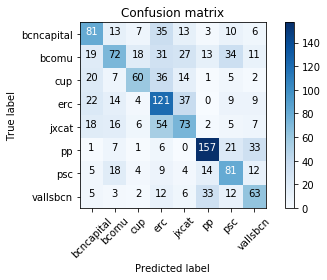

<Figure size 640x480 with 0 Axes>

In [85]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

cm = confusion_matrix(test_tags,predicted_label)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm_plot_labels = text_labels

plot_confusion_matrix(cm, cm_plot_labels)

from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

# Entrenamos con todos los datos

El modelo parece que funciona pues entrenamos con todos los datos. El incremento en accuracy es notable. DL es muy sensible al numero de datos.

In [86]:
print(x_train.shape,x_test.shape)
all_x = np.concatenate((x_train,x_test))
all_y = np.concatenate((y_train,y_test))
print(all_x.shape)
model.load_weights('model.h5')
history = model.fit(all_x, all_y,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=1,
                    validation_split=0.2)

(5775, 50) (1444, 50)
(7219, 50)
Train on 5775 samples, validate on 1444 samples
Epoch 1/10
5775/5775 [==============================] - 3s 551us/step - loss: 1.7692 - acc: 0.2710 - val_loss: 1.4912 - val_acc: 0.4217
Epoch 2/10
5775/5775 [==============================] - 3s 546us/step - loss: 0.6513 - acc: 0.7590 - val_loss: 1.5090 - val_acc: 0.4938
Epoch 3/10
5775/5775 [==============================] - 3s 552us/step - loss: 0.0414 - acc: 0.9882 - val_loss: 1.6959 - val_acc: 0.5118
Epoch 4/10
5775/5775 [==============================] - 3s 559us/step - loss: 0.0034 - acc: 0.9995 - val_loss: 1.8686 - val_acc: 0.5035
Epoch 5/10
5775/5775 [==============================] - 3s 553us/step - loss: 0.0015 - acc: 0.9997 - val_loss: 1.9453 - val_acc: 0.5097
Epoch 6/10
5775/5775 [==============================] - 3s 548us/step - loss: 7.8216e-04 - acc: 0.9998 - val_loss: 2.0289 - val_acc: 0.5090
Epoch 7/10
5775/5775 [==============================] - 3s 546us/step - loss: 6.0696e-04 - acc: 0.9

Creamos el submission file para el kaggle